In [1]:
import numpy as np
import numpy.matlib as mt
import h5py

from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials import align_trials
from ephysvibe.task import task_constants

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

import os 
from matplotlib import cm
from matplotlib import pyplot as plt
import glob
from pathlib import Path
import pickle

from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import permutations
seed = 2023


In [2]:
def reorganize_data(data):
    ps_a_sample     =   np.empty([num_iter, data[0]['sample'].shape[0], data[0]['sample'].shape[0]])
    ps_a_orient     =   np.empty([num_iter, data[0]['orientation'].shape[0], data[0]['orientation'].shape[0]])
    ps_a_color      =   np.empty([num_iter, data[0]['color'].shape[0], data[0]['color'].shape[0]])
    ps_a_neutral    =   np.empty([num_iter, data[0]['neutral'].shape[0], data[0]['neutral'].shape[0]])

    # pt_a_sample=np.empty([num_iter, data[0]['perf test']['sample'].shape[0]])
    # pt_a_orient=np.empty([num_iter, data[0]['perf test']['orientation'].shape[0]])
    # pt_a_color=np.empty([num_iter, data[0]['perf test']['color'].shape[0]])
    # pt_a_neutral=np.empty([num_iter, data[0]['perf test']['neutral'].shape[0]])


    # ps_z_sample=np.empty([num_iter, data[0]['zscored']['sample'].shape[0]])
    # ps_z_orient=np.empty([num_iter, data[0]['zscored']['orientation'].shape[0]])
    # ps_z_color=np.empty([num_iter, data[0]['zscored']['color'].shape[0]])
    # ps_z_neutral=np.empty([num_iter, data[0]['zscored']['neutral'].shape[0]])

    # pt_z_sample=np.empty([num_iter, data[0]['zscored']['perf test']['sample'].shape[0]])
    # pt_z_orient=np.empty([num_iter, data[0]['zscored']['perf test']['orientation'].shape[0]])
    # pt_z_color=np.empty([num_iter, data[0]['zscored']['perf test']['color'].shape[0]])
    # pt_z_neutral=np.empty([num_iter, data[0]['zscored']['perf test']['neutral'].shape[0]])

    for i in range(num_iter):
        ps_a_sample[i,:]   =   data[i]['sample']
        ps_a_orient[i,:]   =   data[i]['orientation']
        ps_a_color[i,:]    =   data[i]['color']
        ps_a_neutral[i,:]  =   data[i]['neutral']
        
        # pt_a_sample[i,:]   =   data[i]['perf test']['sample']
        # pt_a_orient[i,:]   =   data[i]['perf test']['orientation']
        # pt_a_color[i,:]    =   data[i]['perf test']['color']
        # pt_a_neutral[i,:]  =   data[i]['perf test']['neutral']
        
        # ps_z_sample[i,:]   =   data[i]['zscored']['sample']
        # ps_z_orient[i,:]   =   data[i]['zscored']['orientation']
        # ps_z_color[i,:]    =   data[i]['zscored']['color']
        # ps_z_neutral[i,:]  =   data[i]['zscored']['neutral']
        
        # pt_z_sample[i,:]   =   data[i]['zscored']['perf test']['sample']
        # pt_z_orient[i,:]   =   data[i]['zscored']['perf test']['orientation']
        # pt_z_color[i,:]    =   data[i]['zscored']['perf test']['color']
        # pt_z_neutral[i,:]  =   data[i]['zscored']['perf test']['neutral']


    ps_a=   {"sample":ps_a_sample.astype(int), "orientation":ps_a_orient.astype(int), "color":ps_a_color.astype(int), "neutral":ps_a_neutral.astype(int)}
    # pt_a=   {"sample":pt_a_sample, "orientation":pt_a_orient, "color":pt_a_color, "neutral":pt_a_neutral}
    p_a =   {"perf sample": ps_a}# , "perf test": pt_a

    # ps_z=   {"sample":ps_z_sample, "orientation":ps_z_orient, "color":ps_z_color, "neutral":ps_z_neutral}
    # pt_z=   {"sample":pt_z_sample, "orientation":pt_z_orient, "color":pt_z_color, "neutral":pt_z_neutral}
    # p_z =   {"perf sample": ps_z, "perf test": pt_z}

    # p   =   {"averaged": p_a, "zscored": p_z}
    return p_a

In [3]:
def pick_train_test_trials(trials, train_ratio):
    tmp     =   np.random.permutation(trials)
    train   =   tmp[:int((trials.shape[0]*train_ratio))]
    test    =   tmp[int((trials.shape[0]*train_ratio)):]

    train_rep   =   mt.repmat(train, test.shape[0],1)
    test_rep    =   mt.repmat(test, train.shape[0],1)
    if np.where(test_rep-np.transpose(train_rep)==0)[0].shape[0]!=0:
        print("Warnings: similar trials for training and testing")

    return train, test


In [23]:
datas[0].shape[1]

145

In [51]:

datas       =   list(dat[cell]['Sample zscored'] for cell in sel_cells)
datat       =   list(dat[cell]['Test1 zscored'] for cell in sel_cells)
sample_id   =   list(dat[cell]['Sample Id'] for cell in sel_cells) 

num_cells   =   d['num selected lip']
num_iter    =   1
num_train   =   30
num_test    =   10
test_train_ratio    =   1-num_test/num_train

o1c1trials  =   list(np.where(sample_id[i]==11)[0] for i in range(num_cells))#
o1c5trials  =   list(np.where(sample_id[i]==15)[0] for i in range(num_cells))#range(num_cells)
o5c1trials  =   list(np.where(sample_id[i]==51)[0] for i in range(num_cells))#range(num_cells)
o5c5trials  =   list(np.where(sample_id[i]==55)[0] for i in range(num_cells))#range(num_cells)

o1trials    =   list(np.where(np.floor(sample_id[i]/10)==1)[0] for i in range(num_cells))#range(num_cells)
o5trials    =   list(np.where(np.floor(sample_id[i]/10)==5)[0] for i in range(num_cells))#range(num_cells)
c1trials    =   list(np.where(np.floor(sample_id[i]%10)==1)[0] for i in range(num_cells))#range(num_cells)
c5trials    =   list(np.where(np.floor(sample_id[i]%10)==5)[0] for i in range(num_cells))#range(num_cells)

ntrials     =   list(np.where(sample_id[i]==0)[0] for i in range(num_cells))#range(num_cells)
nntrials    =   list(np.where(sample_id[i]!=0)[0] for i in range(num_cells))#range(num_cells)

data_train_c    =   np.empty([datas[0].shape[1]+datat[0].shape[1], num_train*2, num_cells])
data_train_o    =   np.empty([datas[0].shape[1]+datat[0].shape[1], num_train*2, num_cells])
data_train_n    =   np.empty([datas[0].shape[1]+datat[0].shape[1], num_train*2, num_cells])
data_train_s    =   np.empty([datas[0].shape[1]+datat[0].shape[1], num_train*4, num_cells])

data_test_c     = np.empty([datas[0].shape[1]+datat[0].shape[1], num_test*2, num_cells])
data_test_o     = np.empty([datas[0].shape[1]+datat[0].shape[1], num_test*2, num_cells])
data_test_n     = np.empty([datas[0].shape[1]+datat[0].shape[1], num_test*2, num_cells])
data_test_s     = np.empty([datas[0].shape[1]+datat[0].shape[1], num_test*4, num_cells])

y_train     =   np.concatenate([np.zeros(num_train), np.ones(num_train)])
y_test      =   np.concatenate([np.zeros(num_test), np.ones(num_test)])
y_train_s   =   np.concatenate([np.zeros(num_train), np.ones(num_train), np.zeros(num_train)+2, np.ones(num_train)+2])
y_test_s    =   np.concatenate([np.zeros(num_test), np.ones(num_test), np.zeros(num_test)+2, np.ones(num_test)+2])

perf_c      =    np.empty([len(data_train_c), len(data_train_c)])
perf_o      =    np.empty([len(data_train_o), len(data_train_o)])
perf_n      =    np.empty([len(data_train_n), len(data_train_n)])
perf_s      =    np.empty([len(data_train_s), len(data_train_s)])

# trials_train_c  =   []
# trials_train_o  =   []
# trials_train_n  =   []
# trials_train_s  =   []

# trials_test_c   =   []
# trials_test_o   =   []
# trials_test_n   =   []
# trials_test_s   =   []


for i in range(num_cells):
    # color trials
    train_c1, test_c1    =  pick_train_test_trials(c1trials[i], test_train_ratio)
    train_c5, test_c5    =  pick_train_test_trials(c5trials[i], test_train_ratio)
    trials_train_c=np.concatenate([np.random.choice(train_c1, num_train), np.random.choice(train_c5, num_train)])
    trials_test_c=np.concatenate([np.random.choice(test_c1, num_test), np.random.choice(test_c5, num_test)])
    
    # orientation trials  
    train_o1, test_o1    =  pick_train_test_trials(o1trials[i], test_train_ratio)
    train_o5, test_o5    =  pick_train_test_trials(o5trials[i], test_train_ratio)
    trials_train_o=np.concatenate([np.random.choice(train_o1, num_train), np.random.choice(train_o5, num_train)])
    trials_test_o=np.concatenate([np.random.choice(test_o1, num_test), np.random.choice(test_o5, num_test)])
            
    # neutral trials  
    train_n, test_n     =  pick_train_test_trials(ntrials[i], test_train_ratio)
    train_nn, test_nn   =  pick_train_test_trials(nntrials[i], test_train_ratio)
    trials_train_n=np.concatenate([np.random.choice(train_n, num_train), np.random.choice(train_nn, num_train)])
    trials_test_n=np.concatenate([np.random.choice(test_n, num_test), np.random.choice(test_nn, num_test)])
            
    # sample trials
    train_o1c1, test_o1c1    =  pick_train_test_trials(o1c1trials[i], test_train_ratio)
    train_o1c5, test_o1c5    =  pick_train_test_trials(o1c5trials[i], test_train_ratio)
    train_o5c1, test_o5c1    =  pick_train_test_trials(o5c1trials[i], test_train_ratio)
    train_o5c5, test_o5c5    =  pick_train_test_trials(o5c5trials[i], test_train_ratio)
    trials_train_s  =   np.concatenate([np.random.choice(train_o1c1, num_train), np.random.choice(train_o1c5, num_train), np.random.choice(train_o5c1, num_train), np.random.choice(train_o5c5, num_train)])
    trials_test_s   =   np.concatenate([np.random.choice(test_o1c1, num_test), np.random.choice(test_o1c5, num_test), np.random.choice(test_o5c1, num_test), np.random.choice(test_o5c5, num_test)])

    # build matrices of  [timestamp, trials, neurons] dimensions to feed to classifiers[i]]
    data_train_c[:, :, i]   =   np.concatenate([np.transpose(datas[i][trials_train_c]), np.transpose(datat[i][trials_train_c])])
    data_train_o[:, :, i]   =   np.concatenate([np.transpose(datas[i][trials_train_o]), np.transpose(datat[i][trials_train_o])])
    data_train_n[:, :, i]   =   np.concatenate([np.transpose(datas[i][trials_train_n]), np.transpose(datat[i][trials_train_n])])
    data_train_s[:, :, i]   =   np.concatenate([np.transpose(datas[i][trials_train_s]), np.transpose(datat[i][trials_train_s])])

    # data_train_c[datas[i].shape[1]:, :, i]   = np.transpose(datat[i][trials_train_c])
    # data_train_o[datas[i].shape[1]:, :, i]   = np.transpose(datat[i][trials_train_o])
    # data_train_n[datas[i].shape[1]:, :, i]   = np.transpose(datat[i][trials_train_n])
    # data_train_s[datas[i].shape[1]:, :, i]   = np.transpose(datat[i][trials_train_s])

    data_test_c[:, :, i]    =   np.concatenate([np.transpose(datas[i][trials_test_c]), np.transpose(datat[i][trials_test_c])])
    data_test_o[:, :, i]    =   np.concatenate([np.transpose(datas[i][trials_test_o]), np.transpose(datat[i][trials_test_o])])
    data_test_n[:, :, i]    =   np.concatenate([np.transpose(datas[i][trials_test_n]), np.transpose(datat[i][trials_test_n])])
    data_test_s[:, :, i]    =   np.concatenate([np.transpose(datas[i][trials_test_s]), np.transpose(datat[i][trials_test_s])])
    
    
    # data_test_c[datas[i].shape[1]:, :, i]    = np.transpose(datat[i][trials_test_c[i]])
    # data_test_o[datas[i].shape[1]:, :, i]    = np.transpose(datat[i][trials_test_o[i]])
    # data_test_n[datas[i].shape[1]:, :, i]    = np.transpose(datat[i][trials_test_n[i]])
    # data_test_s[datas[i].shape[1]:, :, i]    = np.transpose(datat[i][trials_test_s[i]])     
    # datat_train_c[:, :, i]   = np.transpose(datat[i][trials_train_c[i]])
    # datat_train_o[:, :, i]   = np.transpose(datat[i][trials_train_o[i]])
    # datat_train_n[:, :, i]   = np.transpose(datat[i][trials_train_n[i]])
    # datat_train_s[:, :, i]   = np.transpose(datat[i][trials_train_s[i]])

    # datat_test_c[:, :, i]   = np.transpose(datat[i][trials_test_c[i]])
    # datat_test_o[:, :, i]   = np.transpose(datat[i][trials_test_o[i]])
    # datat_test_n[:, :, i]   = np.transpose(datat[i][trials_test_n[i]])
    # datat_test_s[:, :, i]   = np.transpose(datat[i][trials_test_s[i]])

    # datas_train_c[:datas_train_c.shape[0],:,i]  =   datas_train_c[:, :, i]

In [65]:
model=  SVC(kernel='linear',C=1, decision_function_shape='ovr',gamma='auto',degree=1)

In [80]:
perf_cb=perf_c*0
perf_ob=perf_o*0
perf_nb=perf_n*0
perf_sb=perf_s*0

In [82]:
for time_train in range(data_train_c.shape[0]):
    
    
    model.fit(data_train_c[time_train],y_train)
    for time_test in range(data_train_c.shape[0]):
        y_predict = model.predict(data_test_c[time_test])
        perf_c[time_train,time_test]=np.where(y_predict-y_test==0)[0].shape[0]
        

    model.fit(data_train_o[time_train],y_train)
    for time_test in range(data_train_o.shape[0]):
        y_predict = model.predict(data_test_o[time_test])
        perf_o[time_train,time_test]=np.where(y_predict-y_test==0)[0].shape[0]
        
    model.fit(data_train_n[time_train],y_train)
    for time_test in range(data_train_n.shape[0]):
        y_predict = model.predict(data_test_n[time_test])
        perf_n[time_train,time_test]=np.where(y_predict-y_test==0)[0].shape[0]

    model.fit(data_train_s[time_train],y_train_s)
    for time_test in range(data_train_s.shape[0]):
        y_predict = model.predict(data_test_s[time_test])
        perf_s[time_train,time_test]=np.where(y_predict-y_test_s==0)[0].shape[0]
        # for l in range(data_train_o.shape[1]):
        #     y_predict = model.predict(data_test_o[t])
        #     perf_o[t,l]=np.where(y_predict-y_test==0)[0].shape[0]
    

        # ori_predict = ori.predict(data_test_o[time_test])
        # perf_o[time_train,time_test]=np.where(ori_predict-y_test==0)[0].shape[0]

        # neu_predict = neu.predict(data_test_n[time_test])
        # perf_n[time_train,time_test]=np.where(neu_predict-y_test==0)[0].shape[0]
    
        # sam_predict = sam.predict(data_test_s[time_test])
        # perf_s[time_train,time_test]=np.where(sam_predict-y_test_s==0)[0].shape[0]

In [91]:
perf_o/20

array([[0.45, 0.65, 0.6 , ..., 0.65, 0.7 , 0.65],
       [0.45, 0.6 , 0.6 , ..., 0.6 , 0.55, 0.7 ],
       [0.45, 0.45, 0.45, ..., 0.5 , 0.65, 0.6 ],
       ...,
       [0.4 , 0.5 , 0.4 , ..., 0.5 , 0.55, 0.5 ],
       [0.4 , 0.45, 0.4 , ..., 0.7 , 0.55, 0.5 ],
       [0.4 , 0.45, 0.45, ..., 0.6 , 0.65, 0.55]])

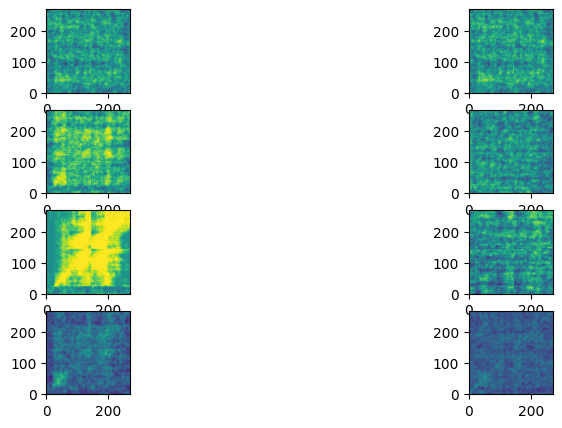

In [93]:
fig, ax      =   plt.subplots(4,2,figsize=(10,5))
ax[0,0].imshow(perf_c/20, vmin=0, vmax=1, origin='lower')
ax[0,1].imshow(perf_cb/20, vmin=0, vmax=1, origin='lower')


ax[1,0].imshow(perf_o/20, vmin=0, vmax=1, origin='lower')
ax[1,1].imshow(perf_ob/20, vmin=0, vmax=1, origin='lower')

ax[2,0].imshow(perf_n/20, vmin=0, vmax=1, origin='lower')
ax[2,1].imshow(perf_nb/20, vmin=0, vmax=1, origin='lower')


ax[3,0].imshow(perf_s/40, vmin=0, vmax=1, origin='lower')
ax[3,1].imshow(perf_sb/40, vmin=0, vmax=1, origin='lower')

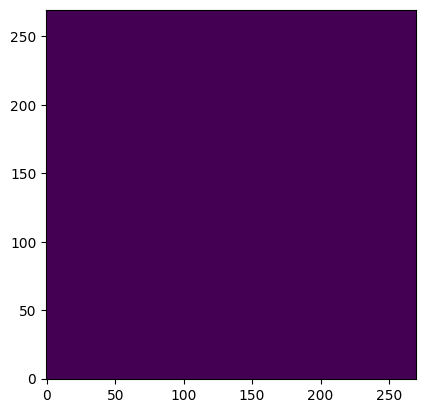

In [79]:
plt.imshow(perf_ob/20, vmin=0, vmax=1, origin='lower')

In [9]:
# def decoding_par(d):
for ii in range(1):
    d=included_lip
    
    dat=d['data']
    num_cells   =   d['num selected lip']
    num_iter    =   1
    num_train   =   30
    num_test    =   10
    test_train_ratio    =   1-num_test/num_train
    
    sel_cells=np.random.permutation(len(dat))
    sel_cells=sel_cells[:num_cells]
    
    names       =   list(dat[i]['name'] for i in sel_cells)
    datas       =   list(dat[i]['Sample zscored'] for i in sel_cells)
    datat       =   list(dat[i]['Test1 zscored'] for i in sel_cells)
    sample_id   =   list(dat[i]['Sample Id'] for i in sel_cells) 
     
    o1c1trials  =   list(np.where(sample_id[i]==11)[0] for i in range(num_cells))#
    o1c5trials  =   list(np.where(sample_id[i]==15)[0] for i in range(num_cells))#range(num_cells)
    o5c1trials  =   list(np.where(sample_id[i]==51)[0] for i in range(num_cells))#range(num_cells)
    o5c5trials  =   list(np.where(sample_id[i]==55)[0] for i in range(num_cells))#range(num_cells)

    o1trials  =   list(np.where(np.floor(sample_id[i]/10)==1)[0] for i in range(num_cells))#range(num_cells)
    o5trials  =   list(np.where(np.floor(sample_id[i]/10)==5)[0] for i in range(num_cells))#range(num_cells)
    c1trials  =   list(np.where(np.floor(sample_id[i]%10)==1)[0] for i in range(num_cells))#range(num_cells)
    c5trials  =   list(np.where(np.floor(sample_id[i]%10)==5)[0] for i in range(num_cells))#range(num_cells)

    ntrials  =   list(np.where(sample_id[i]==0)[0] for i in range(num_cells))#range(num_cells)
    nntrials  =   list(np.where(sample_id[i]!=0)[0] for i in range(num_cells))#range(num_cells)

    data_train_c    =   np.empty([datas[0].shape[1]+datat[0].shape[1], num_train*2, num_cells])
    data_train_o    =   np.empty([datas[0].shape[1]+datat[0].shape[1], num_train*2, num_cells])
    data_train_n    =   np.empty([datas[0].shape[1]+datat[0].shape[1], num_train*2, num_cells])
    data_train_s    =   np.empty([datas[0].shape[1]+datat[0].shape[1], num_train*4, num_cells])
    
    # datat_train_c   =   np.empty([datat[0].shape[1], num_train*2, num_cells])
    # datat_train_o   =   np.empty([datat[0].shape[1], num_train*2, num_cells])
    # datat_train_n   =   np.empty([datat[0].shape[1], num_train*2, num_cells])
    # datat_train_s   =   np.empty([datat[0].shape[1], num_train*4, num_cells])
    
    data_test_c     = np.empty([datas[0].shape[1]+datat[0].shape[1], num_test*2, num_cells])
    data_test_o     = np.empty([datas[0].shape[1]+datat[0].shape[1], num_test*2, num_cells])
    data_test_n     = np.empty([datas[0].shape[1]+datat[0].shape[1], num_test*2, num_cells])
    data_test_s     = np.empty([datas[0].shape[1]+datat[0].shape[1], num_test*4, num_cells])
    
    # datat_test_c    = np.empty([datat[0].shape[1], num_test*2, num_cells])
    # datat_test_o    = np.empty([datat[0].shape[1], num_test*2, num_cells])
    # datat_test_n    = np.empty([datat[0].shape[1], num_test*2, num_cells])
    # datat_test_s    = np.empty([datat[0].shape[1], num_test*4, num_cells])

    y_train     =   np.concatenate([np.zeros(num_train), np.ones(num_train)])
    y_test      =   np.concatenate([np.zeros(num_test), np.ones(num_test)])
    y_train_s   =   np.concatenate([np.zeros(num_train), np.ones(num_train), np.zeros(num_train)+2, np.ones(num_train)+2])
    y_test_s    =   np.concatenate([np.zeros(num_test), np.ones(num_test), np.zeros(num_test)+2, np.ones(num_test)+2])

    perf_c      =    np.empty([len(data_train_c), len(data_train_c)])
    perf_o      =    np.empty([len(data_train_o), len(data_train_o)])
    perf_n      =    np.empty([len(data_train_n), len(data_train_n)])
    perf_s      =    np.empty([len(data_train_s), len(data_train_s)])
    
    # perft_c     =    np.empty([len(datat_train_c), len(datat_train_c)])
    # perft_o     =    np.empty([len(datat_train_o), len(datat_train_o)])
    # perft_n     =    np.empty([len(datat_train_o), len(datat_train_n)])
    # perft_s     =    np.empty([len(datat_train_s), len(datat_train_s)])


    # perf_ct      =    np.empty([len(data_train_c), len(datat_train_c)])
    # perf_ot      =    np.empty([len(data_train_o), len(datat_train_o)])
    # perf_nt      =    np.empty([len(data_train_n), len(datat_train_n)])
    # perf_st      =    np.empty([len(data_train_s), len(datat_train_s)])
    
    # perft_cs     =    np.empty([len(datat_train_c), len(data_train_c)])
    # perft_os     =    np.empty([len(datat_train_o), len(data_train_o)])
    # perft_ns     =    np.empty([len(datat_train_o), len(data_train_n)])
    # perft_ss     =    np.empty([len(datat_train_s), len(data_train_s)])
    
    trials_train_c  =   []
    trials_train_o  =   []
    trials_train_n  =   []
    trials_train_s  =   []

    trials_test_c   =   []
    trials_test_o   =   []
    trials_test_n   =   []
    trials_test_s   =   []

    for i in range(num_cells):
        # color trials
        train_c1, test_c1    =  pick_train_test_trials(c1trials[i], test_train_ratio)
        train_c5, test_c5    =  pick_train_test_trials(c5trials[i], test_train_ratio)
        trials_train_c.append(np.concatenate([np.random.choice(train_c1, num_train), np.random.choice(train_c5, num_train)]))
        trials_test_c.append(np.concatenate([np.random.choice(test_c1, num_test), np.random.choice(test_c5, num_test)]))
        
        # orientation trials  
        train_o1, test_o1    =  pick_train_test_trials(o1trials[i], test_train_ratio)
        train_o5, test_o5    =  pick_train_test_trials(o5trials[i], test_train_ratio)
        trials_train_o.append(np.concatenate([np.random.choice(train_o1, num_train), np.random.choice(train_o5, num_train)]))
        trials_test_o.append(np.concatenate([np.random.choice(test_o1, num_test), np.random.choice(test_o5, num_test)]))
                
        # neutral trials  
        train_n, test_n     =  pick_train_test_trials(ntrials[i], test_train_ratio)
        train_nn, test_nn   =  pick_train_test_trials(nntrials[i], test_train_ratio)
        trials_train_n.append(np.concatenate([np.random.choice(train_n, num_train), np.random.choice(train_nn, num_train)]))
        trials_test_n.append(np.concatenate([np.random.choice(test_n, num_test), np.random.choice(test_nn, num_test)]))
                
        # sample trials
        train_o1c1, test_o1c1    =  pick_train_test_trials(o1c1trials[i], test_train_ratio)
        train_o1c5, test_o1c5    =  pick_train_test_trials(o1c5trials[i], test_train_ratio)
        train_o5c1, test_o5c1    =  pick_train_test_trials(o5c1trials[i], test_train_ratio)
        train_o5c5, test_o5c5    =  pick_train_test_trials(o5c5trials[i], test_train_ratio)
        trials_train_s.append(np.concatenate([np.random.choice(train_o1c1, num_train), np.random.choice(train_o1c5, num_train), np.random.choice(train_o5c1, num_train), np.random.choice(train_o5c5, num_train)]))
        trials_test_s.append(np.concatenate([np.random.choice(test_o1c1, num_test), np.random.choice(test_o1c5, num_test), np.random.choice(test_o5c1, num_test), np.random.choice(test_o5c5, num_test)]))

        # build matrices of  [timestamp, trials, neurons] dimensions to feed to classifiers
        data_train_c[:datas[i].shape[1], :, i]   = np.transpose(datas[i][trials_train_c[i]])
        data_train_o[:datas[i].shape[1], :, i]   = np.transpose(datas[i][trials_train_o[i]])
        data_train_n[:datas[i].shape[1], :, i]   = np.transpose(datas[i][trials_train_n[i]])
        data_train_s[:datas[i].shape[1], :, i]   = np.transpose(datas[i][trials_train_s[i]])

        data_train_c[datas[i].shape[1]:, :, i]   = np.transpose(datat[i][trials_train_c[i]])
        data_train_o[datas[i].shape[1]:, :, i]   = np.transpose(datat[i][trials_train_o[i]])
        data_train_n[datas[i].shape[1]:, :, i]   = np.transpose(datat[i][trials_train_n[i]])
        data_train_s[datas[i].shape[1]:, :, i]   = np.transpose(datat[i][trials_train_s[i]])
   
        
        data_test_c[:datas[i].shape[1], :, i]    = np.transpose(datas[i][trials_test_c[i]])
        data_test_o[:datas[i].shape[1], :, i]    = np.transpose(datas[i][trials_test_o[i]])
        data_test_n[:datas[i].shape[1], :, i]    = np.transpose(datas[i][trials_test_n[i]])
        data_test_s[:datas[i].shape[1], :, i]    = np.transpose(datas[i][trials_test_s[i]])
        
        data_test_c[datas[i].shape[1]:, :, i]    = np.transpose(datat[i][trials_test_c[i]])
        data_test_o[datas[i].shape[1]:, :, i]    = np.transpose(datat[i][trials_test_o[i]])
        data_test_n[datas[i].shape[1]:, :, i]    = np.transpose(datat[i][trials_test_n[i]])
        data_test_s[datas[i].shape[1]:, :, i]    = np.transpose(datat[i][trials_test_s[i]])     
        # datat_train_c[:, :, i]   = np.transpose(datat[i][trials_train_c[i]])
        # datat_train_o[:, :, i]   = np.transpose(datat[i][trials_train_o[i]])
        # datat_train_n[:, :, i]   = np.transpose(datat[i][trials_train_n[i]])
        # datat_train_s[:, :, i]   = np.transpose(datat[i][trials_train_s[i]])

        # datat_test_c[:, :, i]   = np.transpose(datat[i][trials_test_c[i]])
        # datat_test_o[:, :, i]   = np.transpose(datat[i][trials_test_o[i]])
        # datat_test_n[:, :, i]   = np.transpose(datat[i][trials_test_n[i]])
        # datat_test_s[:, :, i]   = np.transpose(datat[i][trials_test_s[i]])

        # datas_train_c[:datas_train_c.shape[0],:,i]  =   datas_train_c[:, :, i]
    for t in range(data_train_c.shape[0]):
        col     =   model.fit(data_train_c[t],y_train)   
        ori     =   model.fit(data_train_o[t],y_train)        
        neu     =   model.fit(data_train_n[t],y_train)
        sam     =   model.fit(data_train_s[t],y_train_s)
        for l in range(data_train_c.shape[1]):
            col_predict = col.predict(data_test_c[l])
            perf_c[t,l]=np.where(col_predict-y_test==0)[0].shape[0]

            ori_predict = ori.predict(data_test_o[l])
            perf_o[t,l]=np.where(ori_predict-y_test==0)[0].shape[0]

            neu_predict = neu.predict(data_test_n[l])
            perf_n[t,l]=np.where(neu_predict-y_test==0)[0].shape[0]
        
            sam_predict = sam.predict(data_test_s[l])
            perf_s[t,l]=np.where(sam_predict-y_test_s==0)[0].shape[0]
        
        # # model.fit(data_train_o[t],y_train)
        # for l in range(data_train_o.shape[1]):
        #     y_predict = model.predict(data_test_o[t])
        #     perf_o[t,l]=np.where(y_predict-y_test==0)[0].shape[0]

        
        # for l in range(data_train_n.shape[1]):
        #     y_predict = model.predict(data_test_o[t])
        #     perf_n[t,l]=np.where(y_predict-y_test==0)[0].shape[0]

        # model.fit(data_train_s[t],y_train_s)
        # y_predict = model.predict(data_test_s[t])
        # perf_s[t,l]=np.where(y_predict-y_test_s==0)[0].shape[0]

        # if t< datat_train_c.shape[0]:
        #     model.fit(datat_train_c[t],y_train)
        #     for l in range()
        #     y_predict = model.predict(datat_test_c[t])
        #     perft_c[t]=np.where(y_predict-y_test==0)[0].shape[0]
            
        #     model.fit(datat_train_o[t],y_train)
        #     y_predict = model.predict(datat_test_o[t])
        #     perft_o[t]=np.where(y_predict-y_test==0)[0].shape[0]

        #     model.fit(datat_train_n[t],y_train)
        #     y_predict = model.predict(datat_test_n[t])
        #     perft_n[t]=np.where(y_predict-y_test==0)[0].shape[0]

        #     model.fit(datat_train_s[t],y_train_s)
        #     y_predict = model.predict(datat_test_s[t])
        #     perft_s[t]=np.where(y_predict-y_test_s==0)[0].shape[0]


    perf=   {"sample": perf_s, "orientation": perf_o, "color":perf_c, "neutral": perf_n}
    # perfa_test  =   {"sample": perft_s, "orientation": perft_o, "color":perft_c, "neutral": perft_n}
    # perf        =   {"perf sample": perfa_sample, "perf test": perfa_test}

    # perfz_sample=   {"sample": perfz_s, "orientation": perfz_o, "color":perfz_c, "neutral":perfz_n}
    # perfz_test  =   {"sample": perfzt_s, "orientation": perfzt_o, "color":perfzt_c, "neutral":perfzt_n}
    # perf_zsc    =   {"perf sample": perfz_sample, "perf test": perfz_test}
    
    # perf        =   {"averaged": perf_avg, "zscored": perf_zsc}
    # return perf

In [5]:
with open('W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/LIPavacti', 'rb') as handle:
    lip = pickle.load(handle)

# with open('W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/pfcavacti', 'rb') as handle:
#     pfc = pickle.load(handle)

# with open('W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/v4avacti', 'rb') as handle:
#     v4 = pickle.load(handle)    

In [6]:
model=  SVC(kernel='linear',C=1, decision_function_shape='ovr',gamma='auto',degree=1)

In [7]:
## decode information in LIP
# select trials for LIP
# av_lip=np.empty([len(lip), lip[0][0]['Sample averaged'].shape[1]])
# max_lip=[]
# mean_lip=[]
tmplip=[]
for i in range(len(lip)):
    # av_lip[i,:]=np.mean(lip[0][i]['Sample averaged'], axis=0)*1000
    # max_lip.append(np.max(av_lip[i,:]))
    # mean_lip.append(np.mean(av_lip[i,:]))
    # if np.max(av_lip[i,:])>=0:
    min_sample=np.min([np.where(lip[0][i]['Sample Id']==11)[0].shape, np.where(lip[0][i]['Sample Id']==15)[0].shape, np.where(lip[0][i]['Sample Id']==51)[0].shape, np.where(lip[0][i]['Sample Id']==55)[0].shape])
    if min_sample>=25:
        tmplip.append(lip[0][i])


included_lip={"data": tmplip, "num selected lip": len(tmplip)}


In [8]:

num_iter    =   10
perf_lip    =   Parallel(n_jobs = -1)(delayed(decoding_par)(included_lip) for cell in tqdm(range(num_iter)))


100%|██████████| 10/10 [00:00<00:00, 76.66it/s]


In [42]:
p_lip   =   reorganize_data(perf_lip)

In [44]:
p_lip['perf sample']['sample'].shape

(10, 270, 270)

In [24]:
data=perf_lip
ps_a_sample     =   np.empty([num_iter, data[0]['sample'].shape[0], data[0]['sample'].shape[0]])*np.nan
ps_a_orient     =   np.empty([num_iter, data[0]['orientation'].shape[0], data[0]['orientation'].shape[0]])*np.nan
ps_a_color      =   np.empty([num_iter, data[0]['color'].shape[0], data[0]['color'].shape[0]])*np.nan
ps_a_neutral    =   np.empty([num_iter, data[0]['neutral'].shape[0], data[0]['neutral'].shape[0]])*np.nan

for i in range(num_iter):
    ps_a_sample[i,:]   =   data[i]['sample']
    ps_a_orient[i,:]   =   data[i]['orientation']
    ps_a_color[i,:]    =   data[i]['color']
    ps_a_neutral[i,:]  =   data[i]['neutral']


In [85]:
## decode information in PFC
# select trials for PFC
av_pfc=np.empty([len(pfc), pfc[0][0]['Sample averaged'].shape[1]])
max_pfc=[]
mean_pfc=[]
tmppfc=[]
for i in range(len(pfc)):
    av_pfc[i,:]=np.mean(pfc[0][i]['Sample averaged'], axis=0)*1000
    max_pfc.append(np.max(av_pfc[i,:]))
    mean_pfc.append(np.mean(av_pfc[i,:]))
    # if np.mean(av_pfc[i,:])>=5:
    #     tmppfc.append(pfc[i])
    min_sample=np.min([np.where(pfc[0][i]['Sample Id']==11)[0].shape, np.where(pfc[0][i]['Sample Id']==15)[0].shape, np.where(pfc[0][i]['Sample Id']==51)[0].shape, np.where(pfc[0][i]['Sample Id']==55)[0].shape])
    if min_sample>=25:
        tmppfc.append(pfc[0][i])

included_pfc={"data": tmppfc, "num selected lip": len(tmplip)}

NameError: name 'pfc' is not defined

In [ ]:
perf_pfc    =   Parallel(n_jobs = -1)(delayed(decoding_par)(included_pfc) for cell in tqdm(range(num_iter)))

In [130]:
p_pfc   =   reorganize_data(perf_pfc)

[{'perf sample': {'sample': array([10.,  7., 12., 18., 11., 10.,  5.,  7.,  6., 10.,  9.,  8.,  8.,
          10.,  6.,  8.,  9.,  9., 12., 15., 10., 13., 11., 15., 19., 23.,
          19., 21., 20., 16., 18., 20., 14., 20., 29., 29., 27., 26., 24.,
          28., 26., 27., 26., 27., 28., 30., 22., 22., 18., 22., 20., 18.,
          22., 22., 21., 22., 23., 24., 22., 22., 18., 20., 19., 22., 22.,
          21., 26., 25., 23., 19., 21., 19., 17., 21., 18., 17., 16., 16.,
           9., 10., 16., 11., 10., 10., 12., 13., 15., 16., 18., 17., 16.,
          20., 19., 18., 20., 20., 17., 18., 24., 25., 25., 23., 12., 11.,
          16., 19., 16., 16., 15., 15., 16., 17., 19., 19., 22., 16., 15.,
          16., 14., 13., 16., 18., 19., 14., 16., 15., 11., 14., 19., 23.,
          18., 21., 17., 14., 13., 14., 14., 16., 17., 16., 17., 23., 22.,
          23., 25.]),
   'orientation': array([10.,  9.,  9., 11., 12., 12., 13., 13., 12., 10., 15., 14., 14.,
          12., 10., 10., 12., 11., 12.

In [100]:
## decode information in V4
# select trials for V4
av_v4=np.empty([len(v4), v4[0][0]['Sample averaged'].shape[1]])
max_v4=[]
mean_v4=[]
tmpv4=[]
for i in range(len(v4)):
    av_v4[i,:]=np.mean(v4[0][i]['Sample averaged'], axis=0)*1000
    max_v4.append(np.max(av_v4[i,:]))
    mean_v4.append(np.mean(av_v4[i,:]))
    # if np.mean(av_v4[i,:])>=5:
    #     tmpv4.append(v4[i])
    min_sample=np.min([np.where(v4[0][i]['Sample Id']==11)[0].shape, np.where(v4[0][i]['Sample Id']==15)[0].shape, np.where(v4[0][i]['Sample Id']==51)[0].shape, np.where(v4[0][i]['Sample Id']==55)[0].shape])
    if min_sample>=25:
        tmpv4.append(v4[0][i])

included_v4={"data": tmpv4, "num selected lip": len(tmplip)}

KeyError: 'neutral'

In [91]:
perf_v4 =   Parallel(n_jobs = -1)(delayed(decoding_par)(included_v4) for cell in tqdm(range(num_iter)))

  0%|          | 0/10 [00:00<?, ?it/s]

NameError: name 'included_pfc' is not defined

In [ ]:
p_v4    =   reorganize_data(perf_v4)

In [115]:
# with open('W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/decoding_perf_lip', 'rb') as handle:
#     perf_lip = pickle.load(handle)

with open('W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/decoding_perf_pfc', 'rb') as handle:
    perf_pfc = pickle.load(handle)
    
# with open('W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/decoding_perf_v4', 'rb') as handle:
#     perf_v4 = pickle.load(handle)

In [3]:
# plips_sample=np.empty([1000, perf_lip[0]['perf sample']['sample'].shape[0]])
# plips_orient=np.empty([1000, perf_lip[0]['perf sample']['sample'].shape[0]])
# plips_color=np.empty([1000, perf_lip[0]['perf sample']['sample'].shape[0]])

# ppfcs_sample=np.empty([1000, perf_lip[0]['perf sample']['sample'].shape[0]])
# ppfcs_orient=np.empty([1000, perf_lip[0]['perf sample']['sample'].shape[0]])
# ppfcs_color=np.empty([1000, perf_lip[0]['perf sample']['sample'].shape[0]])

# pv4s_sample=np.empty([1000, perf_lip[0]['perf sample']['sample'].shape[0]])
# pv4s_orient=np.empty([1000, perf_lip[0]['perf sample']['sample'].shape[0]])
# pv4s_color=np.empty([1000, perf_lip[0]['perf sample']['sample'].shape[0]])



# plipt_sample=np.empty([1000, perf_lip[0]['perf test']['sample'].shape[0]])
# plipt_orient=np.empty([1000, perf_lip[0]['perf test']['sample'].shape[0]])
# plipt_color=np.empty([1000, perf_lip[0]['perf test']['sample'].shape[0]])

# ppfct_sample=np.empty([1000, perf_lip[0]['perf test']['sample'].shape[0]])
# ppfct_orient=np.empty([1000, perf_lip[0]['perf test']['sample'].shape[0]])
# ppfct_color=np.empty([1000, perf_lip[0]['perf test']['sample'].shape[0]])

# pv4t_sample=np.empty([1000, perf_lip[0]['perf test']['sample'].shape[0]])
# pv4t_orient=np.empty([1000, perf_lip[0]['perf test']['sample'].shape[0]])
# pv4t_color=np.empty([1000, perf_lip[0]['perf test']['sample'].shape[0]])

# for i in range(10):
#     plips_sample[i,:]   =   perf_lip[i]['perf sample']['sample']
#     plips_orient[i,:]   =   perf_lip[i]['perf sample']['orientation']
#     plips_color[i,:]    =   perf_lip[i]['perf sample']['color']

#     ppfcs_sample[i,:]   =   perf_pfc[i]['perf sample']['sample']
#     ppfcs_orient[i,:]   =   perf_pfc[i]['perf sample']['orientation']
#     ppfcs_color[i,:]    =   perf_pfc[i]['perf sample']['color']

#     pv4s_sample[i,:]    =   perf_v4[i]['perf sample']['sample']
#     pv4s_orient[i,:]    =   perf_v4[i]['perf sample']['orientation']
#     pv4s_color[i,:]     =   perf_v4[i]['perf sample']['color']
    
#     plipt_sample[i,:]   =   perf_lip[i]['perf test']['sample']
#     plipt_orient[i,:]   =   perf_lip[i]['perf test']['orientation']
#     plipt_color[i,:]    =   perf_lip[i]['perf test']['color']

#     ppfct_sample[i,:]   =   perf_pfc[i]['perf test']['sample']
#     ppfct_orient[i,:]   =   perf_pfc[i]['perf test']['orientation']
#     ppfct_color[i,:]    =   perf_pfc[i]['perf test']['color']

#     pv4t_sample[i,:]    =   perf_v4[i]['perf test']['sample']
#     pv4t_orient[i,:]    =   perf_v4[i]['perf test']['orientation']
#     pv4t_color[i,:]     =   perf_v4[i]['perf test']['color']

KeyError: 0

In [120]:
lips_sig_sample  =   np.empty(plips_sample.shape[1])
lips_sig_color   =   np.empty(plips_color.shape[1])
lips_sig_orient  =   np.empty(plips_orient.shape[1])
lips_sig_neutral =   np.empty(plips_neutral.shape[1])

# pfcs_sig_sample  =   np.empty(ppfcs_sample.shape[1])
# pfcs_sig_color   =   np.empty(ppfcs_color.shape[1])
# pfcs_sig_orient  =   np.empty(ppfcs_orient.shape[1])
# pfcs_sig_neutral =   np.empty(ppfcs_neutral.shape[1])

# v4s_sig_sample  =   np.empty(pv4s_sample.shape[1])
# v4s_sig_color   =   np.empty(pv4s_color.shape[1])
# v4s_sig_orient  =   np.empty(pv4s_orient.shape[1])
# v4s_sig_neutral =   np.empty(pv4s_neutral.shape[1])

lipt_sig_sample  =   np.empty(plipt_sample.shape[1])
lipt_sig_color   =   np.empty(plipt_color.shape[1])
lipt_sig_orient  =   np.empty(plipt_orient.shape[1])
lipt_sig_neutral =   np.empty(plipt_neutral.shape[1])

# pfct_sig_sample  =   np.empty(ppfct_sample.shape[1])
# pfct_sig_color   =   np.empty(ppfct_color.shape[1])
# pfct_sig_orient  =   np.empty(ppfct_orient.shape[1])
# pfct_sig_neutral =   np.empty(ppfct_neutral.shape[1])

# v4t_sig_sample  =   np.empty(pv4t_sample.shape[1])
# v4t_sig_color   =   np.empty(pv4t_color.shape[1])
# v4t_sig_orient  =   np.empty(pv4t_orient.shape[1])
# v4t_sig_neutral =   np.empty(pv4t_neutral.shape[1])

lips_z_sig_sample  =   np.empty(plips_z_sample.shape[1])
lips_z_sig_color   =   np.empty(plips_z_color.shape[1])
lips_z_sig_orient  =   np.empty(plips_z_orient.shape[1])
lips_z_sig_neutral =   np.empty(plips_z_neutral.shape[1])

# pfcs_z_sig_sample  =   np.empty(ppfcs_z_sample.shape[1])
# pfcs_z_sig_color   =   np.empty(ppfcs_z_color.shape[1])
# pfcs_z_sig_orient  =   np.empty(ppfcs_z_orient.shape[1])
# pfcs_z_sig_neutral =   np.empty(ppfcs_z_neutral.shape[1])

# v4s_z_sig_sample  =   np.empty(pv4s_z_sample.shape[1])
# v4s_z_sig_color   =   np.empty(pv4s_z_color.shape[1])
# v4s_z_sig_orient  =   np.empty(pv4s_z_orient.shape[1])
# v4s_z_sig_neutral =   np.empty(pv4s_z_neutral.shape[1])

lipt_z_sig_sample  =   np.empty(plipt_z_sample.shape[1])
lipt_z_sig_color   =   np.empty(plipt_z_color.shape[1])
lipt_z_sig_orient  =   np.empty(plipt_z_orient.shape[1])
lipt_z_sig_neutral =   np.empty(plipt_z_neutral.shape[1])

# pfct_z_sig_sample  =   np.empty(ppfct_z_sample.shape[1])
# pfct_z_sig_color   =   np.empty(ppfct_z_color.shape[1])
# pfct_z_sig_orient  =   np.empty(ppfct_z_orient.shape[1])
# pfct_z_sig_neutral =   np.empty(ppfct_z_neutral.shape[1])

# v4t_z_sig_sample  =   np.empty(pv4t_z_sample.shape[1])
# v4t_z_sig_color   =   np.empty(pv4t_z_color.shape[1])
# v4t_z_sig_orient  =   np.empty(pv4t_z_orient.shape[1])
# v4t_z_sig_neutral =   np.empty(pv4t_z_neutral.shape[1])

for t in range(plips_sample.shape[1]):
    lips_sig_sample[t]   =   np.where(plips_sample[:,t]>10)[0].shape[0]
    lips_sig_color[t]    =   np.where(plips_color[:,t]>10)[0].shape[0]
    lips_sig_orient[t]   =   np.where(plips_orient[:,t]>10)[0].shape[0]
    lips_sig_neutral[t]  =   np.where(plips_neutral[:,t]>10)[0].shape[0]

    # pfcs_sig_sample[t]   =   np.where(ppfcs_sample[:,t]>10)[0].shape[0]
    # pfcs_sig_color[t]    =   np.where(ppfcs_color[:,t]>10)[0].shape[0]
    # pfcs_sig_orient[t]   =   np.where(ppfcs_orient[:,t]>10)[0].shape[0]
    # pfcs_sig_neutral[t]  =   np.where(ppfcs_neutral[:,t]>10)[0].shape[0]


    # v4s_sig_sample[t]   =   np.where(pv4s_sample[:,t]>10)[0].shape[0]
    # v4s_sig_color[t]    =   np.where(pv4s_color[:,t]>10)[0].shape[0]
    # v4s_sig_orient[t]   =   np.where(pv4s_orient[:,t]>10)[0].shape[0]
    # v4s_sig_neutral[t]  =   np.where(pv4s_neutral[:,t]>10)[0].shape[0]
    
    lips_z_sig_sample[t]   =   np.where(plips_z_sample[:,t]>10)[0].shape[0]
    lips_z_sig_color[t]    =   np.where(plips_z_color[:,t]>10)[0].shape[0]
    lips_z_sig_orient[t]   =   np.where(plips_z_orient[:,t]>10)[0].shape[0]
    lips_z_sig_neutral[t]  =   np.where(plips_z_neutral[:,t]>10)[0].shape[0]

    # pfcs_z_sig_sample[t]   =   np.where(ppfcs_z_sample[:,t]>10)[0].shape[0]
    # pfcs_z_sig_color[t]    =   np.where(ppfcs_z_color[:,t]>10)[0].shape[0]
    # pfcs_z_sig_orient[t]   =   np.where(ppfcs_z_orient[:,t]>10)[0].shape[0]
    # pfcs_z_sig_neutral[t]  =   np.where(ppfcs_z_neutral[:,t]>10)[0].shape[0]


    # v4s_z_sig_sample[t]   =   np.where(pv4s_z_sample[:,t]>10)[0].shape[0]
    # v4s_z_sig_color[t]    =   np.where(pv4s_z_color[:,t]>10)[0].shape[0]
    # v4s_z_sig_orient[t]   =   np.where(pv4s_z_orient[:,t]>10)[0].shape[0]
    # v4s_z_sig_neutral[t]  =   np.where(pv4s_z_neutral[:,t]>10)[0].shape[0]

    if t<plipt_sample.shape[1]:
        lipt_sig_sample[t]   =   np.where(plipt_sample[:,t]>10)[0].shape[0]
        lipt_sig_color[t]    =   np.where(plipt_color[:,t]>10)[0].shape[0]
        lipt_sig_orient[t]   =   np.where(plipt_orient[:,t]>10)[0].shape[0]
        lipt_sig_neutral[t]  =   np.where(plipt_neutral[:,t]>10)[0].shape[0]

        # pfct_sig_sample[t]   =   np.where(ppfct_sample[:,t]>10)[0].shape[0]
        # pfct_sig_color[t]    =   np.where(ppfct_color[:,t]>10)[0].shape[0]
        # pfct_sig_orient[t]   =   np.where(ppfct_orient[:,t]>10)[0].shape[0]
        # pfct_sig_neutral[t]  =   np.where(ppfct_neutral[:,t]>10)[0].shape[0]


        # v4t_sig_sample[t]   =   np.where(pv4t_sample[:,t]>10)[0].shape[0]
        # v4t_sig_color[t]    =   np.where(pv4t_color[:,t]>10)[0].shape[0]
        # v4t_sig_orient[t]   =   np.where(pv4t_orient[:,t]>10)[0].shape[0]
        # v4t_sig_neutral[t]  =   np.where(pv4t_neutral[:,t]>10)[0].shape[0]

        lipt_z_sig_sample[t]   =   np.where(plipt_z_sample[:,t]>10)[0].shape[0]
        lipt_z_sig_color[t]    =   np.where(plipt_z_color[:,t]>10)[0].shape[0]
        lipt_z_sig_orient[t]   =   np.where(plipt_z_orient[:,t]>10)[0].shape[0]
        lipt_z_sig_neutral[t]  =   np.where(plipt_z_neutral[:,t]>10)[0].shape[0]

        # pfct_z_sig_sample[t]   =   np.where(ppfct_z_sample[:,t]>10)[0].shape[0]
        # pfct_z_sig_color[t]    =   np.where(ppfct_z_color[:,t]>10)[0].shape[0]
        # pfct_z_sig_orient[t]   =   np.where(ppfct_z_orient[:,t]>10)[0].shape[0]
        # pfct_z_sig_neutral[t]  =   np.where(ppfct_z_neutral[:,t]>10)[0].shape[0]


        # v4t_z_sig_sample[t]   =   np.where(pv4t_z_sample[:,t]>10)[0].shape[0]
        # v4t_z_sig_color[t]    =   np.where(pv4t_z_color[:,t]>10)[0].shape[0]
        # v4t_z_sig_orient[t]   =   np.where(pv4t_z_orient[:,t]>10)[0].shape[0]
        # v4t_z_sig_neutral[t]  =   np.where(pv4t_z_neutral[:,t]>10)[0].shape[0]


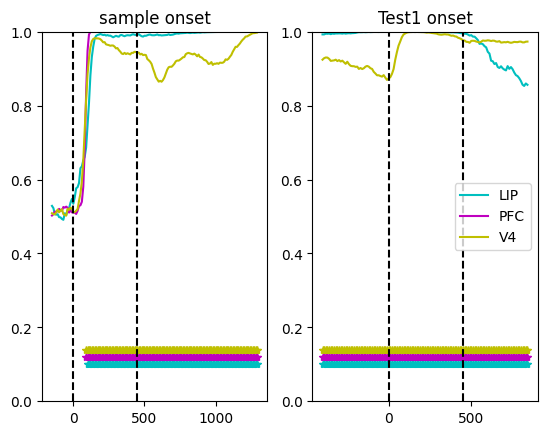

In [161]:
fig, ax     =   plt.subplots(1,2)
time_s=np.arange(start=-150, stop=450*3-50, step=10)
ax[0].plot(time_s, np.mean(plips_neutral, axis=0)/20, 'c', label='LIP')
ax[0].plot(time_s, np.mean(ppfcs_neutral, axis=0)/20, 'm', label='PFC')
ax[0].plot(time_s, np.mean(pv4s_neutral, axis=0)/20, 'y', label='V4')
ax[0].plot(time_s[np.where(lips_sig_neutral>950)],np.ones(lips_sig_neutral[lips_sig_neutral>950].shape[0])/10, 'c*')
ax[0].plot(time_s[np.where(pfcs_sig_neutral>950)],np.ones(pfcs_sig_neutral[pfcs_sig_neutral>950].shape[0])/10+0.02, 'm*')
ax[0].plot(time_s[np.where(v4s_sig_neutral>950)],np.ones(v4s_sig_neutral[v4s_sig_neutral>950].shape[0])/10+0.04, 'y*')
ax[0].plot([0,0], [0, 1],'--k')
ax[0].plot([450,450], [0, 1],'--k')
ax[0].set_ylim(0,1)
ax[0].set_title('sample onset')
plt.subplot(1,2,2)
time_t=np.arange(start=-400, stop=450*2-50, step=10)
ax[1].plot(time_t, np.mean(plipt_neutral, axis=0)/20, 'c', label='LIP')
ax[1].plot(time_t, np.mean(ppfct_neutral, axis=0)/20, 'm', label='PFC')
ax[1].plot(time_t, np.mean(pv4t_neutral, axis=0)/20, 'y', label='V4')
ax[1].plot(time_t[np.where(lipt_sig_neutral>950)],np.ones(lipt_sig_neutral[lipt_sig_neutral>950].shape[0])/10, 'c*')
ax[1].plot(time_t[np.where(pfct_sig_neutral>950)],np.ones(pfct_sig_neutral[pfct_sig_neutral>950].shape[0])/10+0.02, 'm*')
ax[1].plot(time_t[np.where(v4t_sig_neutral>950)],np.ones(v4t_sig_neutral[v4t_sig_neutral>950].shape[0])/10+0.04, 'y*')
ax[1].plot([0,0], [0, 1],'--k')
ax[1].plot([450,450], [0, 1],'--k')
ax[1].set_ylim(0,1)
ax[1].set_title('Test1 onset')
ax[1].legend()

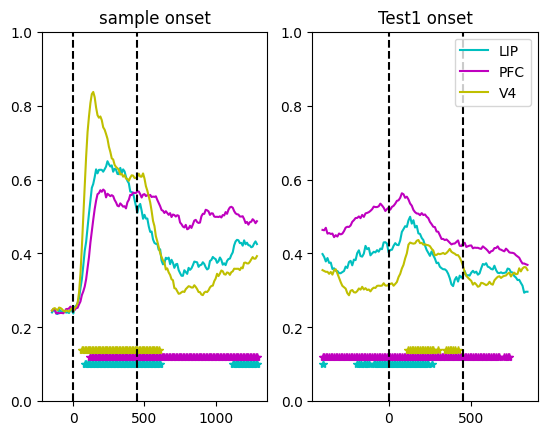

In [121]:
fig, ax     =   plt.subplots(1,2)
time_s=np.arange(start=-150, stop=450*3-50, step=10)
ax[0].plot(time_s, np.mean(plips_sample, axis=0)/40, 'c', label='LIP')
ax[0].plot(time_s, np.mean(ppfcs_sample, axis=0)/40, 'm', label='PFC')
ax[0].plot(time_s, np.mean(pv4s_sample, axis=0)/40, 'y', label='V4')
ax[0].plot(time_s[np.where(lips_sig_sample>950)],np.ones(lips_sig_sample[lips_sig_sample>950].shape[0])/10, 'c*')
ax[0].plot(time_s[np.where(pfcs_sig_sample>950)],np.ones(pfcs_sig_sample[pfcs_sig_sample>950].shape[0])/10+0.02, 'm*')
ax[0].plot(time_s[np.where(v4s_sig_sample>950)],np.ones(v4s_sig_sample[v4s_sig_sample>950].shape[0])/10+0.04, 'y*')
ax[0].plot([0,0], [0, 1],'--k')
ax[0].plot([450,450], [0, 1],'--k')
ax[0].set_ylim(0,1)
ax[0].set_title('sample onset')
plt.subplot(1,2,2)
time_t=np.arange(start=-400, stop=450*2-50, step=10)
ax[1].plot(time_t, np.mean(plipt_sample, axis=0)/40, 'c', label='LIP')
ax[1].plot(time_t, np.mean(ppfct_sample, axis=0)/40, 'm', label='PFC')
ax[1].plot(time_t, np.mean(pv4t_sample, axis=0)/40, 'y', label='V4')
ax[1].plot(time_t[np.where(lipt_sig_sample>950)],np.ones(lipt_sig_sample[lipt_sig_sample>950].shape[0])/10, 'c*')
ax[1].plot(time_t[np.where(pfct_sig_sample>950)],np.ones(pfct_sig_sample[pfct_sig_sample>950].shape[0])/10+0.02, 'm*')
ax[1].plot(time_t[np.where(v4t_sig_sample>950)],np.ones(v4t_sig_sample[v4t_sig_sample>950].shape[0])/10+0.04, 'y*')
ax[1].plot([0,0], [0, 1],'--k')
ax[1].plot([450,450], [0, 1],'--k')
ax[1].set_ylim(0,1)
ax[1].set_title('Test1 onset')
ax[1].legend()

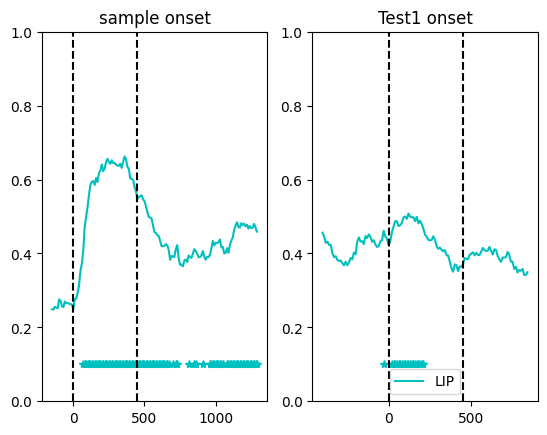

In [124]:
fig, ax     =   plt.subplots(1,2)
time_s=np.arange(start=-150, stop=450*3-50, step=10)
ax[0].plot(time_s, np.mean(plips_z_sample, axis=0)/40, 'c', label='LIP')
# ax[0].plot(time_s, np.mean(ppfcs_z_sample, axis=0)/40, 'm', label='PFC')
# ax[0].plot(time_s, np.mean(pv4s_z_sample, axis=0)/40, 'y', label='V4')
ax[0].plot(time_s[np.where(lips_z_sig_sample>950)],np.ones(lips_z_sig_sample[lips_z_sig_sample>950].shape[0])/10, 'c*')
# ax[0].plot(time_s[np.where(pfcs_z_sig_sample>950)],np.ones(pfcs_z_sig_sample[pfcs_z_sig_sample>950].shape[0])/10+0.02, 'm*')
# ax[0].plot(time_s[np.where(v4s_z_sig_sample>950)],np.ones(v4s_z_sig_sample[v4s_z_sig_sample>950].shape[0])/10+0.04, 'y*')
ax[0].plot([0,0], [0, 1],'--k')
ax[0].plot([450,450], [0, 1],'--k')
ax[0].set_ylim(0,1)
ax[0].set_title('sample onset')
plt.subplot(1,2,2)
time_t=np.arange(start=-400, stop=450*2-50, step=10)
ax[1].plot(time_t, np.mean(plipt_z_sample, axis=0)/40, 'c', label='LIP')
# ax[1].plot(time_t, np.mean(ppfct_z_sample, axis=0)/40, 'm', label='PFC')
# ax[1].plot(time_t, np.mean(pv4t_z_sample, axis=0)/40, 'y', label='V4')
ax[1].plot(time_t[np.where(lipt_z_sig_sample>990)],np.ones(lipt_z_sig_sample[lipt_z_sig_sample>990].shape[0])/10, 'c*')
# ax[1].plot(time_t[np.where(pfct_z_sig_sample>950)],np.ones(pfct_z_sig_sample[pfct_z_sig_sample>950].shape[0])/10+0.02, 'm*')
# ax[1].plot(time_t[np.where(v4t_z_sig_sample>950)],np.ones(v4t_z_sig_sample[v4t_z_sig_sample>950].shape[0])/10+0.04, 'y*')
ax[1].plot([0,0], [0, 1],'--k')
ax[1].plot([450,450], [0, 1],'--k')
ax[1].set_ylim(0,1)
ax[1].set_title('Test1 onset')
ax[1].legend()

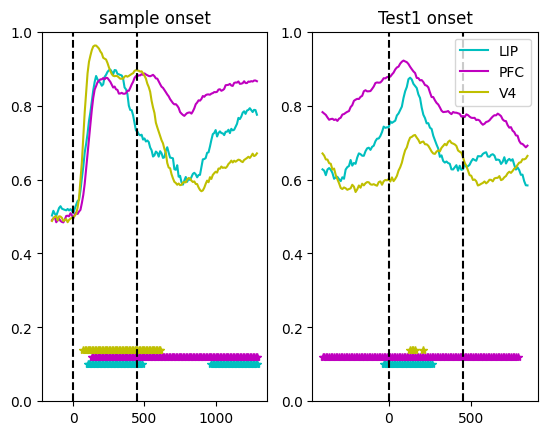

In [163]:
fig, ax     =   plt.subplots(1,2)
time_s=np.arange(start=-150, stop=450*3-50, step=10)
ax[0].plot(time_s, np.mean(plips_orient, axis=0)/20, 'c', label='LIP')
ax[0].plot(time_s, np.mean(ppfcs_orient, axis=0)/20, 'm', label='PFC')
ax[0].plot(time_s, np.mean(pv4s_orient, axis=0)/20, 'y', label='V4')
ax[0].plot(time_s[np.where(lips_sig_orient>950)],np.ones(lips_sig_orient[lips_sig_orient>950].shape[0])/10, 'c*')
ax[0].plot(time_s[np.where(pfcs_sig_orient>950)],np.ones(pfcs_sig_orient[pfcs_sig_orient>950].shape[0])/10+0.02, 'm*')
ax[0].plot(time_s[np.where(v4s_sig_orient>950)],np.ones(v4s_sig_orient[v4s_sig_orient>950].shape[0])/10+0.04, 'y*')
ax[0].set_ylim(0,1)
ax[0].plot([0,0], [0, 1],'--k')
ax[0].plot([450,450], [0, 1],'--k')
ax[0].set_title('sample onset')
plt.subplot(1,2,2)
time_t=np.arange(start=-400, stop=450*2-50, step=10)
ax[1].plot(time_t, np.mean(plipt_orient, axis=0)/20, 'c', label='LIP')
ax[1].plot(time_t, np.mean(ppfct_orient, axis=0)/20, 'm', label='PFC')
ax[1].plot(time_t, np.mean(pv4t_orient, axis=0)/20, 'y', label='V4')
ax[1].plot(time_t[np.where(lipt_sig_orient>950)],np.ones(lipt_sig_orient[lipt_sig_orient>950].shape[0])/10, 'c*')
ax[1].plot(time_t[np.where(pfct_sig_orient>950)],np.ones(pfct_sig_orient[pfct_sig_orient>950].shape[0])/10+0.02, 'm*')
ax[1].plot(time_t[np.where(v4t_sig_orient>950)],np.ones(v4t_sig_orient[v4t_sig_orient>950].shape[0])/10+0.04, 'y*')
ax[1].plot([0,0], [0, 1],'--k')
ax[1].plot([450,450], [0, 1],'--k')
ax[1].set_ylim(0,1)
ax[1].set_title('Test1 onset')
ax[1].legend()

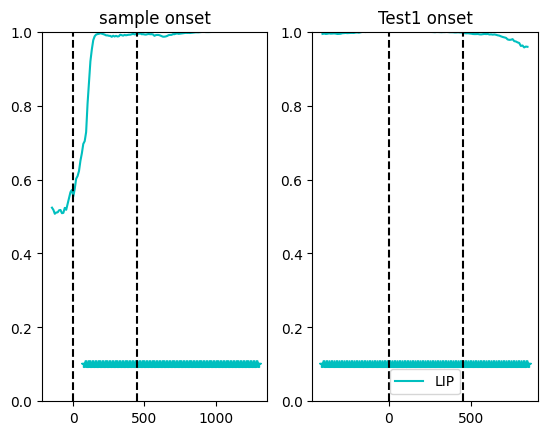

In [125]:
fig, ax     =   plt.subplots(1,2)
time_s=np.arange(start=-150, stop=450*3-50, step=10)
ax[0].plot(time_s, np.mean(plips_z_orient, axis=0)/20, 'c', label='LIP')
# ax[0].plot(time_s, np.mean(ppfcs_orient, axis=0)/20, 'm', label='PFC')
# ax[0].plot(time_s, np.mean(pv4s_orient, axis=0)/20, 'y', label='V4')
ax[0].plot(time_s[np.where(lips_z_sig_orient>950)],np.ones(lips_z_sig_orient[lips_z_sig_orient>950].shape[0])/10, 'c*')
# ax[0].plot(time_s[np.where(pfcs_sig_orient>950)],np.ones(pfcs_sig_orient[pfcs_sig_orient>950].shape[0])/10+0.02, 'm*')
# ax[0].plot(time_s[np.where(v4s_sig_orient>950)],np.ones(v4s_sig_orient[v4s_sig_orient>950].shape[0])/10+0.04, 'y*')
ax[0].set_ylim(0,1)
ax[0].plot([0,0], [0, 1],'--k')
ax[0].plot([450,450], [0, 1],'--k')
ax[0].set_title('sample onset')
plt.subplot(1,2,2)
time_t=np.arange(start=-400, stop=450*2-50, step=10)
ax[1].plot(time_t, np.mean(plipt_z_orient, axis=0)/20, 'c', label='LIP')
# ax[1].plot(time_t, np.mean(ppfct_orient, axis=0)/20, 'm', label='PFC')
# ax[1].plot(time_t, np.mean(pv4t_orient, axis=0)/20, 'y', label='V4')
ax[1].plot(time_t[np.where(lipt_z_sig_orient>950)],np.ones(lipt_z_sig_orient[lipt_z_sig_orient>950].shape[0])/10, 'c*')
# ax[1].plot(time_t[np.where(pfct_sig_orient>950)],np.ones(pfct_sig_orient[pfct_sig_orient>950].shape[0])/10+0.02, 'm*')
# ax[1].plot(time_t[np.where(v4t_sig_orient>950)],np.ones(v4t_sig_orient[v4t_sig_orient>950].shape[0])/10+0.04, 'y*')
ax[1].plot([0,0], [0, 1],'--k')
ax[1].plot([450,450], [0, 1],'--k')
ax[1].set_ylim(0,1)
ax[1].set_title('Test1 onset')
ax[1].legend()

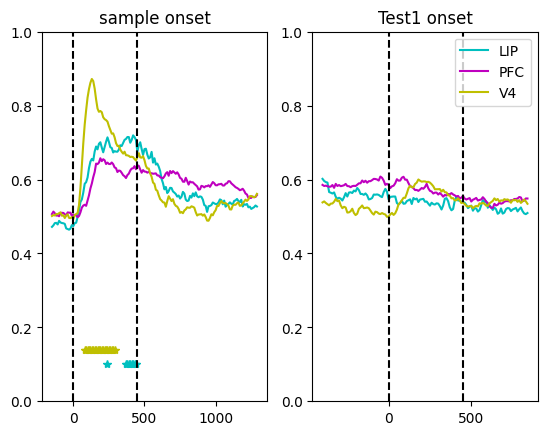

In [164]:
fig, ax     =   plt.subplots(1,2)
time_s=np.arange(start=-150, stop=450*3-50, step=10)
ax[0].plot(time_s, np.mean(plips_color, axis=0)/20, 'c', label='LIP')
ax[0].plot(time_s, np.mean(ppfcs_color, axis=0)/20, 'm', label='PFC')
ax[0].plot(time_s, np.mean(pv4s_color, axis=0)/20, 'y', label='V4')
ax[0].plot(time_s[np.where(lips_sig_color>950)],np.ones(lips_sig_color[lips_sig_color>950].shape[0])/10, 'c*')
ax[0].plot(time_s[np.where(pfcs_sig_color>950)],np.ones(pfcs_sig_color[pfcs_sig_color>950].shape[0])/10+0.02, 'm*')
ax[0].plot(time_s[np.where(v4s_sig_color>950)],np.ones(v4s_sig_color[v4s_sig_color>950].shape[0])/10+0.04, 'y*')
ax[0].set_ylim(0,1)
ax[0].plot([0,0], [0, 1],'--k')
ax[0].plot([450,450], [0, 1],'--k')
ax[0].set_title('sample onset')
plt.subplot(1,2,2)
time_t=np.arange(start=-400, stop=450*2-50, step=10)
ax[1].plot(time_t, np.mean(plipt_color, axis=0)/20, 'c', label='LIP')
ax[1].plot(time_t, np.mean(ppfct_color, axis=0)/20, 'm', label='PFC')
ax[1].plot(time_t, np.mean(pv4t_color, axis=0)/20, 'y', label='V4')
ax[1].plot(time_t[np.where(lipt_sig_color>950)],np.ones(lipt_sig_color[lipt_sig_color>950].shape[0])/10, 'c*')
ax[1].plot(time_t[np.where(pfct_sig_color>950)],np.ones(pfct_sig_color[pfct_sig_color>950].shape[0])/10+0.02, 'm*')
ax[1].plot(time_t[np.where(v4t_sig_color>950)],np.ones(v4t_sig_color[v4t_sig_color>950].shape[0])/10+0.04, 'y*')
ax[1].set_ylim(0,1)
ax[1].plot([0,0], [0, 1],'--k')
ax[1].plot([450,450], [0, 1],'--k')
ax[1].set_title('Test1 onset')
ax[1].legend()

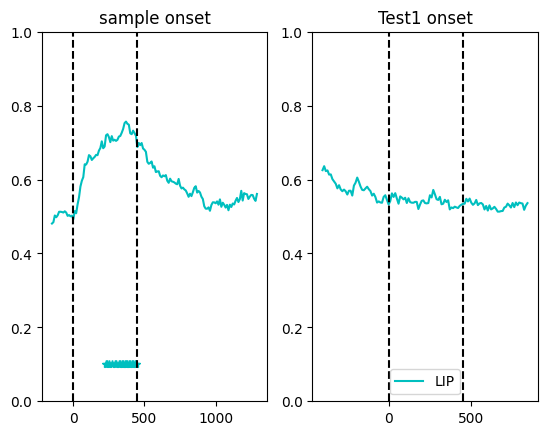

In [127]:
fig, ax     =   plt.subplots(1,2)
time_s=np.arange(start=-150, stop=450*3-50, step=10)
ax[0].plot(time_s, np.mean(plips_z_color, axis=0)/20, 'c', label='LIP')
# ax[0].plot(time_s, np.mean(ppfcs_color, axis=0)/20, 'm', label='PFC')
# ax[0].plot(time_s, np.mean(pv4s_color, axis=0)/20, 'y', label='V4')
ax[0].plot(time_s[np.where(lips_z_sig_color>950)],np.ones(lips_z_sig_color[lips_z_sig_color>950].shape[0])/10, 'c*')
# ax[0].plot(time_s[np.where(pfcs_sig_color>950)],np.ones(pfcs_sig_color[pfcs_sig_color>950].shape[0])/10+0.02, 'm*')
# ax[0].plot(time_s[np.where(v4s_sig_color>950)],np.ones(v4s_sig_color[v4s_sig_color>950].shape[0])/10+0.04, 'y*')
ax[0].set_ylim(0,1)
ax[0].plot([0,0], [0, 1],'--k')
ax[0].plot([450,450], [0, 1],'--k')
ax[0].set_title('sample onset')
plt.subplot(1,2,2)
time_t=np.arange(start=-400, stop=450*2-50, step=10)
ax[1].plot(time_t, np.mean(plipt_z_color, axis=0)/20, 'c', label='LIP')
# ax[1].plot(time_t, np.mean(ppfct_color, axis=0)/20, 'm', label='PFC')
# ax[1].plot(time_t, np.mean(pv4t_color, axis=0)/20, 'y', label='V4')
ax[1].plot(time_t[np.where(lipt_z_sig_color>950)],np.ones(lipt_z_sig_color[lipt_z_sig_color>950].shape[0])/10, 'c*')
# ax[1].plot(time_t[np.where(pfct_sig_color>950)],np.ones(pfct_sig_color[pfct_sig_color>950].shape[0])/10+0.02, 'm*')
# ax[1].plot(time_t[np.where(v4t_sig_color>950)],np.ones(v4t_sig_color[v4t_sig_color>950].shape[0])/10+0.04, 'y*')
ax[1].set_ylim(0,1)
ax[1].plot([0,0], [0, 1],'--k')
ax[1].plot([450,450], [0, 1],'--k')
ax[1].set_title('Test1 onset')
ax[1].legend()

In [49]:
A=np.arange(20)

Rt=20
B=np.empty([100,Rt])*np.nan
S=np.empty(100)*np.nan
for i in range(100):
    B[i,:]  =   np.random.choice(A, Rt)
    S[i]    =   20-np.unique(B[i,:]).shape[0]


(array([10., 26.,  0., 25.,  0., 22., 15.,  0.,  1.,  1.]),
 array([0.25, 0.28, 0.31, 0.34, 0.37, 0.4 , 0.43, 0.46, 0.49, 0.52, 0.55]),
 <BarContainer object of 10 artists>)

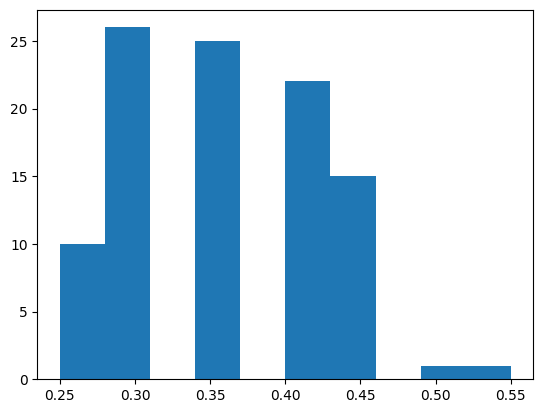

In [50]:
plt.hist(S/20)